In [27]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from torchtext.data import get_tokenizer
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F


## Load Data

In [28]:
# Load data
def load_data(path, verbose=False):
    li = []
    for filename in os.listdir(path):
        df = pd.read_csv(os.path.join(path, filename))
        li.append(df)
    output = pd.concat(li)
    if verbose:
        print(output.head())
        print(f'The shape of the data is: {output.shape}')
    return output

# Define paths
path_to_data = "../challenge_data/"
path_to_training_tweets = os.path.join(path_to_data, "train_tweets")
path_to_eval_tweets = os.path.join(path_to_data, "eval_tweets")
output_path = "evaluation_predictions.csv"

In [29]:
df = load_data(path_to_training_tweets)

df = df.head(100000)

print(df)

         ID  MatchID  PeriodID  EventType      Timestamp  \
0       2_0        2         0          0  1403538600000   
1       2_0        2         0          0  1403538600000   
2       2_0        2         0          0  1403538600000   
3       2_0        2         0          0  1403538600000   
4       2_0        2         0          0  1403538600000   
...     ...      ...       ...        ...            ...   
13152  3_10        3        10          1  1403798422000   
13153  3_10        3        10          1  1403798422000   
13154  3_10        3        10          1  1403798422000   
13155  3_10        3        10          1  1403798422000   
13156  3_10        3        10          1  1403798422000   

                                                   Tweet  
0      RT @soccerdotcom: If #ESP beats #AUS we'll giv...  
1      Visit the #SITEP official web site here http:/...  
2      RT @soccerdotcom: If #ESP beats #AUS we'll giv...  
3      RT @worldsoccershop: If there is a w

In [30]:
### Grouping tweets who have same timestamp by concatenating them
MAX_SUBGROUP = 150

# Create an array of random integers in {0, ..., MAX_SUBGROUP} of size len(df_train)
df["random_id"] = np.random.randint(0, MAX_SUBGROUP, len(df))
df_bis = df.groupby(['ID', "MatchID", "PeriodID", "EventType", "random_id"])['Tweet'].apply(lambda x: ' '.join(x)).reset_index().drop(columns='random_id')
df_bis = df_bis.sample(frac=1).reset_index(drop=True)
print(df_bis)

          ID  MatchID  PeriodID  EventType  \
0      2_116        2       116          0   
1       2_56        2        56          1   
2        3_5        3         5          1   
3        2_3        2         3          0   
4       2_96        2        96          1   
...      ...      ...       ...        ...   
19959   2_33        2        33          0   
19960   2_43        2        43          0   
19961   2_65        2        65          1   
19962   2_17        2        17          1   
19963   2_32        2        32          0   

                                                   Tweet  
0      RT @Avnionics: #ESP 3-0 !! Mataaaa !! Awesome ...  
1      RT @FIFAWorldCup: PHOTO: @Guaje7Villa's 9th #w...  
2      RT @IGN: In ten minutes, it's #USA v #GER & #P...  
3      RT @soccerdotcom: If #AUS beats #ESP we'll giv...  
4      RT @FutbolBible: David Villa in tears on the S...  
...                                                  ...  
19959  RT @soccerdotcom: If #ESP b

# Preprocessing

In [31]:
def preprocessing(df):
    df["Tweet"] = df["Tweet"].str.lower()
    return df

In [32]:
preprocessing(df_bis)
print(df_bis)

          ID  MatchID  PeriodID  EventType  \
0      2_116        2       116          0   
1       2_56        2        56          1   
2        3_5        3         5          1   
3        2_3        2         3          0   
4       2_96        2        96          1   
...      ...      ...       ...        ...   
19959   2_33        2        33          0   
19960   2_43        2        43          0   
19961   2_65        2        65          1   
19962   2_17        2        17          1   
19963   2_32        2        32          0   

                                                   Tweet  
0      rt @avnionics: #esp 3-0 !! mataaaa !! awesome ...  
1      rt @fifaworldcup: photo: @guaje7villa's 9th #w...  
2      rt @ign: in ten minutes, it's #usa v #ger & #p...  
3      rt @soccerdotcom: if #aus beats #esp we'll giv...  
4      rt @futbolbible: david villa in tears on the s...  
...                                                  ...  
19959  rt @soccerdotcom: if #esp b

## Create dictionary from tweets

In [33]:
train, test = train_test_split(df_bis, test_size=0.3, random_state=42)

In [34]:
tokenizer = get_tokenizer("basic_english")
number_of_words_in_dict = 1000

def create_vocab(df, column_name, tokenizer, number_of_words_in_dict):
    words = []
    for text in df[column_name]:
        words.extend(tokenizer(text))
    vocab = dict(Counter(words).most_common(number_of_words_in_dict))
    return vocab

vocab = create_vocab(train, 'Tweet', tokenizer, number_of_words_in_dict)
keywords = list(vocab.keys())

['.', 'rt', '#esp', '//t', 'http', '#aus', 'the', '!', "'", 'a', 'to', 'in', ',', 'for', 'villa', 'david', 'and', 'spain', 's', 'if', 'we', '#worldcup', 'goal', 'follow', 'enter', 'his', 'away', 'give', 'll', 'vs', 'on', 'winner', 'of', 'is', 'tears', 'game', '#ned', 'jersey', 'after', '#chi', 'with', 'as', 'last', '#ausesp', '2', '@soccerdotcom', 'off', 'one', '@fifaworldcup', 'beats', '1', 'it', 'match', 'he', 'world', 'retweet', 'time', 'bench', ')', 'this', 'cup', 'lucky', '(', '2014', 'final', 'ghana', '–', 'what', '&', '@guaje7villa', '#gha', 'torres', '@worldsoccershop', '#joinin', 'will', '0', 'scores', 'goals', '-', 'at', 'their', 'htt…', '@juanmata8', '?', 'substituted', '3-0', '#worldcup2014', 'win', 'player', 'today', 'pair', 'be', 'being', 'us', 'lead', 'career', '0-3', 'i', 'group', 'mata', 'there', '0-1', '2-0', 'co/hbwuu21sgj', '#spain', 'finish', 'juan', 'from', 'playing', 'co/kqglbslp…', '@espnfc', 'you', 'can', 'https', 'subbed', 'by', 'v', 'australia', 'scored', '#p

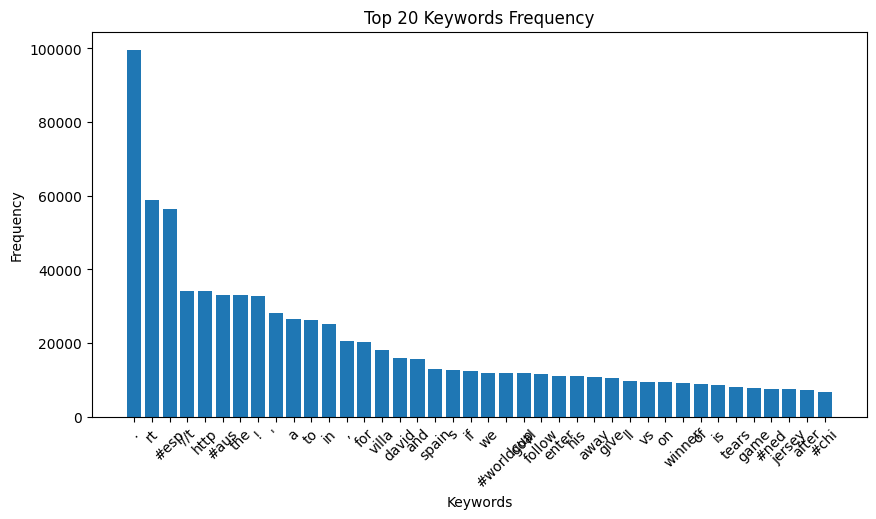

In [35]:
print(keywords)
print(vocab)

# Plot histogram of the top 20 keywords
top_keywords = keywords[:40]
top_counts = [vocab[word] for word in top_keywords]

plt.figure(figsize=(10, 5))
plt.bar(top_keywords, top_counts)
plt.xlabel('Keywords')
plt.ylabel('Frequency')
plt.title('Top 20 Keywords Frequency')
plt.xticks(rotation=45)
plt.show()

# Embedding

In [36]:
def extract_keyword_frequencies(tweets, keywords):
    feature_matrix = []
    for i, text in enumerate(tweets):
        tokens = tokenizer(text) # ex : 'Hello, I am a test' -> ['hello', 'i', 'am', 'a', 'test']
        token_counts = Counter(tokens)
        len_token = max(len(tokens), 1)
        frequencies = [token_counts.get(keyword, 0)/len_token for keyword in keywords]
        feature_matrix.append(frequencies)
    feature_matrix = np.array(feature_matrix)
    return feature_matrix 

In [37]:
print(Counter(tokenizer('Hello, I am a test')))
print(extract_keyword_frequencies(['Hello, I am a test'], ['hello', 'i', 'am']))

Counter({'hello': 1, ',': 1, 'i': 1, 'am': 1, 'a': 1, 'test': 1})
[[0.16666667 0.16666667 0.16666667]]


In [38]:
train_X = extract_keyword_frequencies(train['Tweet'], keywords)

In [39]:
test_X = extract_keyword_frequencies(test['Tweet'], keywords)

# Training

In [40]:
# Standardize the feature matrix
scaler = StandardScaler()
train_X = scaler.fit_transform(train_X) # train_X -> (train_X - mean(train_X)) / std(train_X)
test_X = scaler.transform(test_X)

In [41]:
# Labels
train_y = np.array(train['EventType']).reshape(-1, 1).flatten()
test_y = np.array(test['EventType']).reshape(-1, 1).flatten()

train_y = torch.tensor(train_y, dtype=torch.float32).view(-1, 1)
test_y = torch.tensor(test_y, dtype=torch.float32).view(-1, 1)

In [42]:
print(f"train_X shape: {train_X.shape}, train_y shape: {train_y.shape}")
print(f"test_X shape: {test_X.shape}, test_y shape: {test_y.shape}")

print(f"Number of NaNs in train_X: {np.isnan(train_X).sum()}")
print(f"Number of NaNs in train_y: {np.isnan(train_y).sum()}")


train_X shape: (13974, 1000), train_y shape: torch.Size([13974, 1])
test_X shape: (5990, 1000), test_y shape: torch.Size([5990, 1])
Number of NaNs in train_X: 0
Number of NaNs in train_y: 0


In [43]:
torch.tensor(train_X, dtype=torch.float32)

tensor([[-0.1263,  1.4273, -0.7439,  ..., -0.0574, -0.0501, -0.0453],
        [ 0.1536, -0.0874,  0.1451,  ..., -0.0574, -0.0501, -0.0453],
        [ 1.7949, -0.9164,  0.4727,  ..., -0.0574, -0.0501, -0.0453],
        ...,
        [-1.3684,  1.8406,  0.3085,  ..., -0.0574, -0.0501, -0.0453],
        [-0.0992, -0.4838, -1.9902,  ..., -0.0574, -0.0501, -0.0453],
        [ 0.3914,  0.3489, -0.3036,  ..., -0.0574, -0.0501, -0.0453]])

In [ ]:
trainset = TensorDataset(torch.tensor(train_X, dtype=torch.float32), train_y)
testset = TensorDataset(torch.tensor(test_X, dtype=torch.float32), test_y)

/tmp/ipykernel_747953/2990160709.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  trainset = TensorDataset(torch.tensor(train_X, dtype=torch.float32), torch.tensor(train_y, dtype=torch.float32))
/tmp/ipykernel_747953/2990160709.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  testset = TensorDataset(torch.tensor(test_X, dtype=torch.float32), torch.tensor(test_y, dtype=torch.float32))


In [45]:
trainset = TensorDataset(torch.tensor(train_X, dtype=torch.float32, device='cpu'),
                         torch.tensor(train_y, dtype=torch.long, device='cpu'))
testset = TensorDataset(torch.tensor(test_X, dtype=torch.float32, device='cpu'),
                        torch.tensor(test_y, dtype=torch.long, device='cpu'))

/tmp/ipykernel_747953/205104358.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(train_y, dtype=torch.long, device='cpu'))
/tmp/ipykernel_747953/205104358.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(test_y, dtype=torch.long, device='cpu'))


In [46]:
# Create TensorDatasets and DataLoaders
batch_size = 64

train_y = np.array(train['EventType']).reshape(-1, 1).flatten()
trainset = TensorDataset(torch.tensor(train_X, dtype=torch.float32),
                         torch.tensor(train_y, dtype=torch.float32))  # Use float32 for BCELoss

In [47]:
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)

In [48]:
class NNModel(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim, dropouts):
        super().__init__()
        assert len(hidden_dims) == len(dropouts)
        self.layers = nn.ModuleList()
        in_dim = input_dim
        for hidden_dim, dropout in zip(hidden_dims, dropouts):
            self.layers.append(nn.Linear(in_dim, hidden_dim))
            self.layers.append(nn.ReLU())
            self.layers.append(nn.BatchNorm1d(hidden_dim))
            self.layers.append(nn.Dropout(dropout))
            in_dim = hidden_dim
        self.output_layer = nn.Linear(in_dim, output_dim)
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x = self.output_layer(x)
        return torch.sigmoid(x)


In [49]:
def train_model(model, train_loader, test_loader, optimizer, criterion, device, num_epochs=10, scheduler=None):
    history = {'train_loss': [], 'val_loss': [], 'val_accuracy': []}
    for epoch in range(num_epochs):
        # Scheduler
        if scheduler:
            scheduler.step()
        # Training
        model.train()
        train_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                val_loss += criterion(outputs, labels).item()
                predicted = (outputs > 0.5).float()
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
        val_accuracy = correct / total
        history['train_loss'].append(train_loss / len(train_loader))
        history['val_loss'].append(val_loss / len(test_loader))
        history['val_accuracy'].append(val_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss/len(train_loader):.4f}, "
              f"Val Loss: {val_loss/len(test_loader):.4f}, Val Accuracy: {val_accuracy:.4f}")

    return history

In [50]:
def plot_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.legend()
    plt.title('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(history['val_accuracy'], label='Val Accuracy')
    plt.legend()
    plt.title('Accuracy')
    plt.show()

In [51]:
# Hyperparameters
input_dim = train_X.shape[1]
hidden_dims = [64]
dropouts = [0.2]
output_dim = 1

model = NNModel(input_dim, hidden_dims, output_dim, dropouts)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# Loss and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Train the model
history = train_model(model, train_loader, test_loader, optimizer, criterion, device)

# Plot training history
plot_history(history)


ValueError: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])) is deprecated. Please ensure they have the same size.